In [33]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# !pip install tensorflow-addons


In [36]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

# import psutil
# import humanize
# import os, time
# import GPUtil as GPU

print(tf.__version__)

2.3.0


In [3]:
# GPUs = GPU.getGPUs()
# # only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def worker():
#   while True:
#     process = psutil.Process(os.getpid())
#     print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
#     print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
#     time.sleep(6)

# import threading
# t = threading.Thread(target=worker, name='Monitor')
# t.start()

In [4]:
# import os
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [5]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [6]:
data_df = pd.read_csv("/content/drive/My Drive/Colab_Notebooks/nela10.csv")

In [7]:
data_df.Reliability.value_counts()

0    44582
2    12575
Name: Reliability, dtype: int64

In [8]:
data_df.Reliability = data_df.Reliability.map({0:0, 2:1})

In [9]:
data_df.shape

(57157, 11)

In [10]:
data_df.content.drop_duplicates().shape

(54823,)

In [11]:
data_df['content'] = data_df['content'].str.replace('\n', ' ').str.strip()

In [12]:
data_df[(data_df.content.str.len()> 0) & (data_df.content.str.len()< 30)][['content','Reliability']]

,content,Reliability
4399,# Rod Rosenstein to step down,0
4623,# Veteran being held in Iran,0
16909,# Democrats Without Clothes,0
17054,Visit the post for more.,0
17059,# The Making of Amazon Prime,0
17109,Visit the post for more.,0
17133,# End the War in Afghanistan,0
17354,The State of the Shutdown,0
17441,# Trump's Not-So-Bully Pulpit,0
17534,The Art of the Fail?,0


In [13]:
data_df.drop( data_df[data_df.content.str.len() < 30].index, inplace=True)

In [14]:
data_df.head()

,id,date,source,title,content,author,url,published,published_utc,collection_utc,Reliability
0,abcnews--2019-01-30--Who is Stacey Abrams the ...,2019-01-30,abcnews,"Who is Stacey Abrams, the Democrat who will re...","Last November, Stacey Abrams, a Democrat who r...",Cheyenne Haslett,https://abcnews.go.com/Politics/stacey-abrams-...,2019-01-30 19:10:47+00:00,1548893447,1567550233,0
1,abcnews--2019-01-30--Ban government shutdowns ...,2019-01-30,abcnews,Ban government shutdowns? Some Republicans and...,As lawmakers scramble to negotiate a border se...,"Benjamin Siegel,\nTrish Turner\n",https://abcnews.go.com/Politics/ban-government...,2019-01-30 17:29:04+00:00,1548887344,1567550233,0
2,abcnews--2019-01-30--Democrats renew push for ...,2019-01-30,abcnews,Democrats renew push for equal pay for equal work,Ten years after President Barack Obama signed ...,John Parkinson,https://abcnews.go.com/Politics/dems-renew-pus...,2019-01-30 21:35:45+00:00,1548902145,1567550233,0
3,abcnews--2019-01-30--Trump attacks intel chief...,2019-01-30,abcnews,Trump attacks intel chiefs after they contradi...,"President Donald Trump on Wednesday declared ""...",Meridith Mcgraw,https://abcnews.go.com/Politics/trump-attacks-...,2019-01-30 17:03:40+00:00,1548885820,1567550233,0
4,abcnews--2019-01-30--Border security battle be...,2019-01-30,abcnews,Border security battle begins as Congress grap...,Republicans and Democrats on the exclusive com...,"John Parkinson,\nBenjamin Siegel\n",https://abcnews.go.com/Politics/border-securit...,2019-01-30 15:09:47+00:00,1548878987,1567550233,0


In [15]:
#Keep only content, Reliability as columns
data_df = data_df.drop(['id','date','source','title','author','url','published','published_utc','collection_utc'],axis=1)

In [16]:
data_df.head()

,content,Reliability
0,"Last November, Stacey Abrams, a Democrat who r...",0
1,As lawmakers scramble to negotiate a border se...,0
2,Ten years after President Barack Obama signed ...,0
3,"President Donald Trump on Wednesday declared ""...",0
4,Republicans and Democrats on the exclusive com...,0


In [17]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = train_test_split(data_df['content'], data_df['Reliability'], test_size=0.20, random_state=42)

In [18]:
train_y.value_counts(), valid_y.value_counts()

(0    35609
 1    10023
 Name: Reliability, dtype: int64, 0    8869
 1    2539
 Name: Reliability, dtype: int64)

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x.values, train_y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((valid_x.values, valid_y.values))

In [20]:
for feat, targ in train_dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: b'Thousands of festival-goers at Glastonbury formed Extinction Rebellion\'s hourglass symbol in a bid to draw attention to climate change issues.  The protest group joined forces with long-time event partner Greenpeace in a call to join a climate-climate rebellion.  The campaigners marched through Worthy Farm led by Extinction Rebellion\'s pink "Tell the Truth" boat, which was last seen in London\'s Oxford Circus when the group brought parts of the British capital to a standstill in April.  They called on ordinary people to join a youth strike planned for September, which they said aimed to force government and business to take the climate emergency seriously.  Activist Lizzy Haughton said while sitting in the middle of the symbol: "I think people are finally beginning to realise that, in order to tackle the climate and ecological emergency, we are going to have to be radical."  Gail Bradbrook, Extinction Rebellion co-founder, said the demonstration had been made particularly

In [21]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [22]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'If you\xe2\x80\x99ve been following Peter Schiff for his prediction of the 2008 financial collapse or strictly because of his affinity for gold, then you\xe2\x80\x99re probably aware that he is not a fan of Bitcoin, but would he be interested in gold-backed smart contracts?  The United States Federal Reserve cut interest rates by another quarter-point on Sept. 18 following the European Central Bank\xe2\x80\x99s Sept. 12 announcement on its negative interest rates and decision to re-introduce quantitative easing. With negative-yielding bonds looking like a shaky refuge from the storm looming on the horizon, prominent investors such as Ray Dalio, Paul Tudor Jones and Stan Druckenmiller have been suggesting gold as a safe haven from what has been called a world war of currencies, with China and Russia appearing particularly keen to weaken the U.S. dollar\xe2\x80\x99s political hegemony.  Meanwhile, central banks around the world have been on the largest gold-buying spree since 

**Create the text encoder**

In [24]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [25]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'that', 'for',
       'is', 'on', 'with', 'was', 'it', 'as', 'he', 'said', 'at', 'be'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed output_sequence_length):

In [26]:
encoded_example = encoder(train_x.to_list()[1])[:3].numpy()
encoded_example

array([  6, 203,   1])

In [27]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [28]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [50]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5 )])

In [52]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
713/713 [==============================] - 167s 234ms/step - loss: 0.2868 - accuracy: 0.8789 - f1_score: 0.6597 - val_loss: 0.2964 - val_accuracy: 0.8740 - val_f1_score: 0.6533
Epoch 2/10
713/713 [==============================] - 167s 234ms/step - loss: 0.2785 - accuracy: 0.8824 - f1_score: 0.6747 - val_loss: 0.3041 - val_accuracy: 0.8854 - val_f1_score: 0.7179
Epoch 3/10
713/713 [==============================] - 165s 232ms/step - loss: 0.2734 - accuracy: 0.8864 - f1_score: 0.6872 - val_loss: 0.2962 - val_accuracy: 0.8844 - val_f1_score: 0.7094
Epoch 4/10
713/713 [==============================] - 170s 238ms/step - loss: 0.2676 - accuracy: 0.8872 - f1_score: 0.6893 - val_loss: 0.2956 - val_accuracy: 0.8854 - val_f1_score: 0.7150
Epoch 5/10
713/713 [==============================] - 170s 238ms/step - loss: 0.2630 - accuracy: 0.8899 - f1_score: 0.6981 - val_loss: 0.2887 - val_accuracy: 0.8885 - val_f1_score: 0.7060
Epoch 6/10
713/713 [==============================] - 169s 2

In [54]:
test_loss, test_acc, test_f1_score = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

179/179 [==============================] - 24s 132ms/step - loss: 0.2926 - accuracy: 0.8860 - f1_score: 0.6964
Test Loss: 0.29258260130882263
Test Accuracy: 0.8860448598861694


(0.0, 0.3071553952991962)

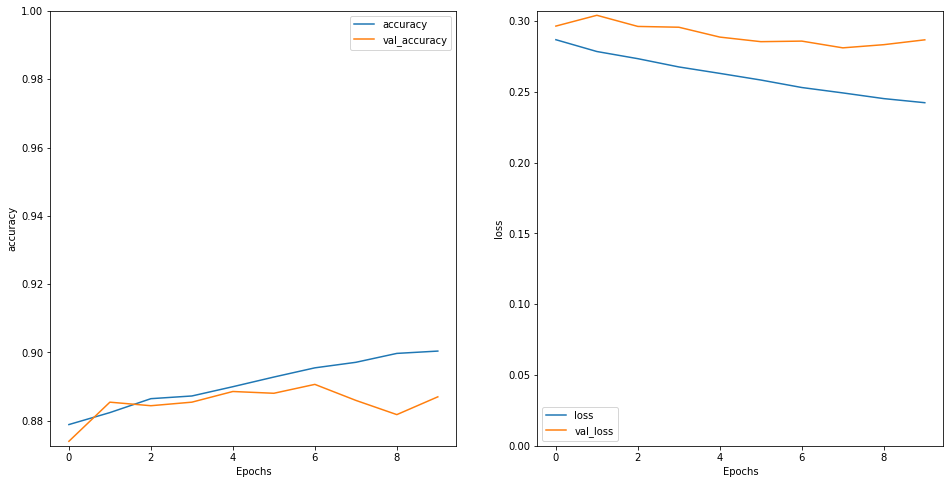

In [55]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [58]:
#saving a model in HDF5 format
#model is a tf.keras.Model object created using any of the above methods
model.save("/content/drive/My Drive/Colab_Notebooks/rnn_lstm_v1.tf", save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab_Notebooks/rnn_lstm_v1.tf/assets


In [57]:
tf.__version__

'2.3.0'

In [67]:
history = model.fit(train_dataset, epochs=6,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/6
713/713 [==============================] - 160s 225ms/step - loss: 0.2386 - accuracy: 0.9027 - f1_score: 0.7390 - val_loss: 0.2818 - val_accuracy: 0.8865 - val_f1_score: 0.7086
Epoch 2/6
713/713 [==============================] - 162s 227ms/step - loss: 0.2363 - accuracy: 0.9036 - f1_score: 0.7424 - val_loss: 0.2780 - val_accuracy: 0.8891 - val_f1_score: 0.7133
Epoch 3/6
713/713 [==============================] - 161s 226ms/step - loss: 0.2328 - accuracy: 0.9055 - f1_score: 0.7480 - val_loss: 0.2998 - val_accuracy: 0.8844 - val_f1_score: 0.7032
Epoch 4/6
713/713 [==============================] - 161s 226ms/step - loss: 0.2297 - accuracy: 0.9081 - f1_score: 0.7562 - val_loss: 0.2830 - val_accuracy: 0.8901 - val_f1_score: 0.7291
Epoch 5/6
713/713 [==============================] - 160s 224ms/step - loss: 0.2287 - accuracy: 0.9076 - f1_score: 0.7543 - val_loss: 0.2800 - val_accuracy: 0.8906 - val_f1_score: 0.7147
Epoch 6/6
713/713 [==============================] - 162s 228ms/s

In [68]:
test_loss, test_acc, test_f1_score = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

179/179 [==============================] - 23s 130ms/step - loss: 0.2931 - accuracy: 0.8821 - f1_score: 0.6722
Test Loss: 0.29311513900756836
Test Accuracy: 0.8821002840995789


(0.0, 0.30339077636599543)

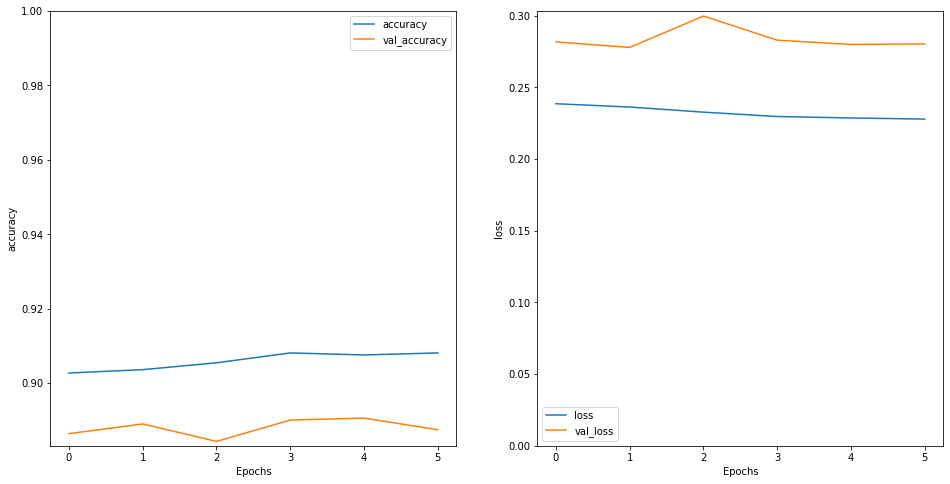

In [69]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

**Stacking more LSTM layers**

In [60]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [61]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5 )])

In [62]:
history2 = model2.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
713/713 [==============================] - 312s 437ms/step - loss: 0.4958 - accuracy: 0.7824 - f1_score: 0.0194 - val_loss: 0.3882 - val_accuracy: 0.8135 - val_f1_score: 0.3194
Epoch 2/10
713/713 [==============================] - 310s 435ms/step - loss: 0.3680 - accuracy: 0.8361 - f1_score: 0.4601 - val_loss: 0.3366 - val_accuracy: 0.8573 - val_f1_score: 0.5994
Epoch 3/10
713/713 [==============================] - 304s 426ms/step - loss: 0.3306 - accuracy: 0.8571 - f1_score: 0.5741 - val_loss: 0.3213 - val_accuracy: 0.8714 - val_f1_score: 0.6545
Epoch 4/10
713/713 [==============================] - 304s 426ms/step - loss: 0.3133 - accuracy: 0.8672 - f1_score: 0.6163 - val_loss: 0.3158 - val_accuracy: 0.8755 - val_f1_score: 0.6766
Epoch 5/10
713/713 [==============================] - 303s 425ms/step - loss: 0.3024 - accuracy: 0.8714 - f1_score: 0.6320 - val_loss: 0.3051 - val_accuracy: 0.8740 - val_f1_score: 0.6483
Epoch 6/10
713/713 [==============================] - 298s 4

In [64]:
test_loss, test_acc, test_f1_score = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

179/179 [==============================] - 42s 232ms/step - loss: 0.2913 - accuracy: 0.8840 - f1_score: 0.6982
Test Loss: 0.29129236936569214
Test Accuracy: 0.8840287327766418


(0.0, 0.5070985183119774)

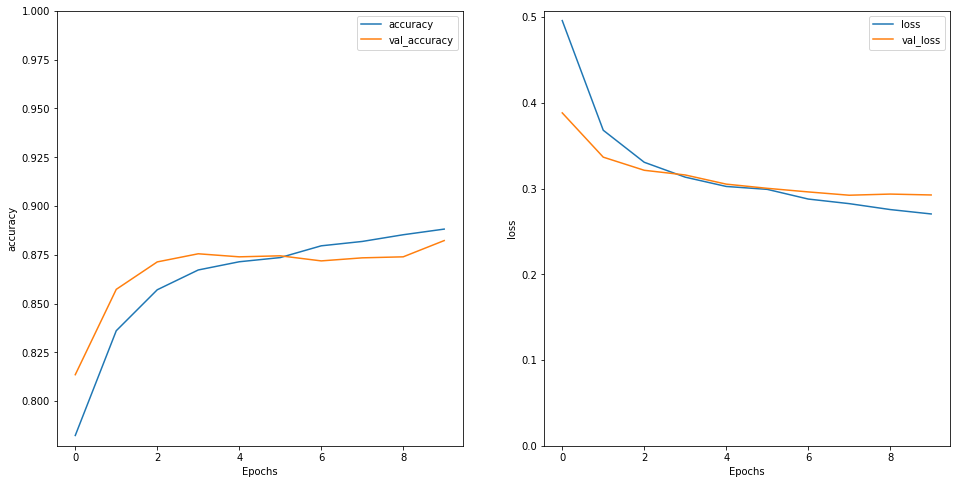

In [65]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history2, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history2, 'loss')
plt.ylim(0,None)

In [66]:
#saving a model in HDF5 format
#model is a tf.keras.Model object created using any of the above methods
model.save("/content/drive/My Drive/Colab_Notebooks/rnn_lstm2_v1.tf", save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab_Notebooks/rnn_lstm2_v1.tf/assets


**GRU**